### Importing relevant Libraries

 1. OS for data handling functions
2. GC for garbage collection
3. Numpy and Pandas for math and data handling operations
4. seaborn and matplotlib for vizualization

In [27]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dt
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.metrics import r2_score, roc_auc_score, mean_absolute_error
from scipy.stats import pearsonr
from joblib import parallel_backend

data_path = 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
    
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [14, 8]  # plot width and height

### Time Series Cross Validation
Cross Validation is the first step. Here we implement a "purged rolling time-series Cross Validation" and apply it in hyperparameter tuning for a basic estimator.

We can specify a gap between each train and validation split. This is important because even though the group aspect keeps whole days together, we suspect that the anonymized features have some kind of lag or window calculations in them (which would be standard for financial features). By introducing a gap, we mitigate the risk that we leak information from train into validation

we can specify the size of the train and validation splits in terms of number of days. The ability to specify a validation set size is new and the the ability to specify days, as opposed to samples, is new.
The code for PurgedTimeSeriesSplit is below. I've hiden it becaused it is really meant to act as an imported class. If you want to see the code and copy for your work, click on the "Code" box.

Here we use a Time Series cross-validator variant with non-overlapping groups. Allows for a gap in groups to avoid potentially leaking info from train into test if the model has windowed or lag features. Provides train/test indices to split time series data samples that are observed at fixed time intervals according to a third-party provided group. In each split, test indices must be higher than before, and thus shuffling in cross validator is inappropriate. This cross-validation object is a variation of :class:`KFold`. In the kth split, it returns first k folds as train set and the (k+1)th fold as test set.

In [11]:
# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class k_fold_cross_validation(_BaseKFold):
    """Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def timeseries_train_test_split(self, X, y=None, groups=None):
        """
        Splits data into training and test set.
        
        Input
        ----------
        X : (n_samples, n_features)
            
        y : (n_samples,)
            
        groups :  (n_samples,)
        Group labels for the samples used while splitting the dataset into
        train/test set.
        
        Output
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

### Configuration

In order to be a proper cross validation with a meaningful overall CV score, you need to choose the same INC2021, INC2020, INC2019, INC2018, INC2017, INCCOMP, INCSUPP, and DEPTH_NETS, WIDTH_NETS for each fold. If your goal is to just run lots of experiments, then you can choose to have a different experiment in each fold. Then each fold is like a holdout validation experiment. When you find a configuration you like, you can use that configuration for all folds.

DEVICE - is CPU or GPU
SEED - a different seed produces a different triple stratified kfold split.
FOLDS - number of folds. Best set to 3, 5, or 15 but can be any number between 2 and 15
LOAD_STRICT - This controls whether to load strict at proposed here

INC2021 - This controls whether to include the extra historical prices during 2021.

INC2020 - This controls whether to include the extra historical prices during 2020.

INC2019 - This controls whether to include the extra historical prices during 2019.

INC2018 - This controls whether to include the extra historical prices during 2018.

INC2017 - This controls whether to include the extra historical prices during 2017.

INCCOMP - This controls whether to include the original data of the competition.

INCSUPP - This controls whether to include the supplemented train data that was released with the competition.

N_ESTIMATORS - is a list of length FOLDS. These are n_estimators for each fold. For maximum speed, it is best to use the smallest number of estimators as your GPU or CPU allows.

MAX_DEPTH - is a list of length FOLDS. These are max_depth for each fold. For maximum speed, it is best to use the smallest number of estimators as your GPU or CPU allows.

LEARNING_RATE - is a list of length FOLDS. These are max_depth for each fold.


In [ ]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

### Load the training and asset detail files.

The dataset consists of data in the following format and structure

#### train.csv - The training set

timestamp - A timestamp for the minute covered by the row.

Asset_ID - An ID code for the cryptoasset.

Count - The number of trades that took place this minute.

Open - The USD price at the beginning of the minute.

High - The highest USD price during the minute.

Low - The lowest USD price during the minute.

Close - The USD price at the end of the minute.

Volume - The number of cryptoasset u units traded during the minute.

VWAP - The volume-weighted average price for the minute.

Target - 15 minute residualized returns. 

Weight - Weight, defined by the competition hosts here

Asset_Name - Human readable Asset name.

example_test.csv - An example of the data that will be delivered by the time series API.

#### example_sample_submission.csv - An example of the data that will be delivered by the time series API. The data is just copied from train.csv.

#### asset_details.csv - Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric.

#### supplemental_train.csv - After the submission period is over this file's data will be replaced with cryptoasset prices from the submission period. In the Evaluation phase, the train, train supplement, and test set will be contiguous in time, apart from any missing data. The current copy, which is just filled approximately the right amount of data from train.csv is provided as a placeholder.

There are 14 coins in the dataset. There are 4 years in the full dataset.

In [12]:
# Now we create helper function to load all the data from the dataset and organize according to the timestamp

# container for extra data files for future phase 2 work with larger live datasets for each crypto currency
extra_data_files = {0: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Binance', 
                    2: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Bitcoin Cash', 
                    1: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Bitcoin', 
                    3: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Cardano', 
                    4: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Dogecoin', 
                    5: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/EOS', 
                    6: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Ethereum', 
                    7: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Ethereum Classic', 
                    8: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/IOTA', 
                    9: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Litecoin', 
                    11: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Monero', 
                    10: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Maker', 
                    12: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/Stellar', 
                    13: 'C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/extra data/TRON'}

orig_df_train = dt.fread('C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/train.csv').to_pandas()
df_asset_details = dt.fread('C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/asset_details.xlsx').to_pandas()
supp_df_train = dt.fread('C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/supplemental_train.csv').to_pandas()
assets_details = dt.fread('C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/asset_details.xlsx').to_pandas()
asset_weight_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Weight'].tolist()[idx] for idx in range(len(assets_details))}
asset_name_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Asset_Name'].tolist()[idx] for idx in range(len(assets_details))}

# function to load data per asset ID from the asset_details.csv file.
def load_training_data_for_asset(asset_id):
    dfs = []
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    else INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())
    
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
    if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
    df = df.sort_values('date')
    return df

# function to load all the assets together
def load_data_for_all_assets():
    dfs = []
    for asset_id in list(extra_data_files.keys()): dfs.append(load_training_data_for_asset(asset_id))
    return pd.concat(dfs)

In [13]:
DEVICE = 'GPU'

# Cross Validation PARAMETERS
FOLDS = 5
GROUP_GAP = 130
MAX_TEST_GROUP_SIZE = 180
MAX_TRAIN_GROUP_SIZE = 280

# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
LOAD_STRICT = True

# Which dataset to include? The full train set or the supplementary train test? 1 = Yes, 0 = No. We use the full set for now.
INCCOMP = 1
INCSUPP = 0

train_data = load_data_for_all_assets()
test = dt.fread('C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/example_test.csv').to_pandas()
sample_prediction_df = dt.fread('C:/Users/nahus/OneDrive/Northeastern University/Courses/DS 5500 - Capstone/Crypto Data/example_sample_submission.csv').to_pandas()
print("Loaded all data!")

Loaded all data!


In [14]:
# Two features from the competition tutorial rules page. These features are also called candlesticks.
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

In [15]:
# A function to detect and fill all the NaN and Inf values with 0
def fill_nan_inf(df):
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    return df

train_data['date'] = pd.to_datetime(train_data['timestamp'], unit = 's')
train_data = train_data.sort_values('date')
groups = pd.factorize(train_data['date'].dt.day.astype(str) + '_' + train_data['date'].dt.month.astype(str) + '_' + train_data['date'].dt.year.astype(str))[0]
dates = train_data['date'].copy()
target = train_data['Target'].copy()
timestamp = train_data['timestamp'].copy()
train_data.drop(columns = 'Target', inplace = True)
train_data = reduce_mem_usage(train_data)
assets_idx = train_data['Asset_ID']
train_data = get_features(train_data)
train_data['Asset_ID'] = assets_idx
train_data['groups'] = groups
train_data['date'] = dates
train_data = reduce_mem_usage(train_data)
train_data['Target'] = target
train_data['timestamp'] = timestamp
train_data['Weight'] = train_data['Asset_ID'].map(asset_weight_dict)

train_data = fill_nan_inf(train_data)
test = fill_nan_inf(test)

feature_names = [i for i in train_data.columns if i not in ['Target', 'date', 'timestamp', 'VWAP', 'Asset_ID', 'groups', 'Weight']]

Memory usage of dataframe is 1695.38 MB
Memory usage after optimization is: 974.84 MB
Decreased by 42.5%
Memory usage of dataframe is 1229.15 MB
Memory usage after optimization is: 1102.00 MB
Decreased by 10.3%


### LightGBM has many parameters. We will use the same Cross Validation scheme (Purged Group Time Series Split) so that the results are comparable. To search for the best parameters, however, we will use a Baysian optimizer, Optuna.

In [ ]:
import optuna

y_labels = train_data['Target'].values
X_train = train_data[feature_names].values
weights = train_data['Weight'].values
groups = train_data['groups'].values

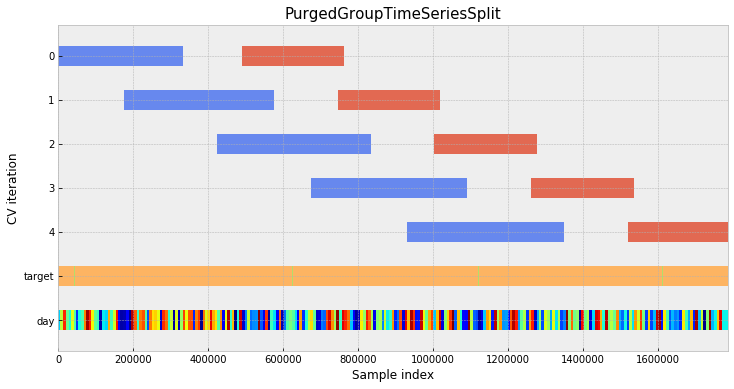

In [18]:
def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    cmap_cv = plt.cm.coolwarm
    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))    
    for ii, (tr, tt) in enumerate(list(cv.timeseries_train_test_split(X=X, y=y, groups=group))):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0        
        ax.scatter(range(len(indices)), [ii + .5] * len(indices), c=indices, marker='_', lw=lw, cmap=cmap_cv, vmin=-.2, vmax=1.2)
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Set3)
    ax.scatter(range(len(X)), [ii + 2.5] * len(X), c=group, marker='_', lw=lw, cmap=cmap_data)
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration", ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(12, 20)):
    try: plt.close()
    except: pass
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    plt.title('Feature Importances')
    sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
    plt.show()
    
asset_id = 0
df = load_training_data_for_asset(asset_id)
df_proc = get_features(df)
df_proc['date'] = df['date'].copy()
df_proc['y'] = df['Target']
df_proc = df_proc.dropna(how="any")
X_temp = df_proc.drop("y", axis=1)
y_temp = df_proc["y"]
groups_temp = pd.factorize(X_temp['date'].dt.day.astype(str) + '_' + X_temp['date'].dt.month.astype(str) + '_' + X_temp['date'].dt.year.astype(str))[0]
X_temp = X_temp.drop(columns = 'date')

fig, ax = plt.subplots(figsize = (12, 6))
cv = k_fold_cross_validation(n_splits = FOLDS, group_gap = GROUP_GAP, max_train_group_size=MAX_TRAIN_GROUP_SIZE, max_test_group_size=MAX_TEST_GROUP_SIZE)
plot_cv_indices(cv, X_temp, y_temp, groups_temp, ax, FOLDS, lw=20)

In [28]:
cv = k_fold_cross_validation(n_splits = FOLDS,
    group_gap = GROUP_GAP,
    max_train_group_size = MAX_TRAIN_GROUP_SIZE,
    max_test_group_size = MAX_TEST_GROUP_SIZE
)

# Optuna is an automatic hyperparameter optimization software framework, particularly designed for machine learning. 
# It features an imperative, define-by-run style user API. 
# Thanks to our define-by-run API, the code written with Optuna enjoys high modularity, 
# and the user of Optuna can dynamically construct the search spaces for the hyperparameters.

def objective(trial, cv=cv, cv_fold_func=np.average):
    # Optuna suggest params
    param_lgb = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        'device': 'gpu',
    }    
    # setup the pieline
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()
    param_lgb['verbose'] = 0
    clf = LGBMRegressor(**param_lgb)

    pipe = Pipeline(steps=[
        ('imputer', imp_mean),
        ('scaler', scaler),
        ('catb', clf)
    ])

    # fit for all folds and return composite MAE score
    maes = []
    for i, (train_idx, valid_idx) in enumerate(cv.timeseries_train_test_split(
        X_train,
        y_labels,
        groups=groups)):
        
        train_data = X_train[train_idx, :], y_labels[train_idx]
        valid_data = X_train[valid_idx, :], y_labels[valid_idx]
        
        _ = pipe.fit(X_train[train_idx, :], y_labels[train_idx])
        preds = pipe.predict(X_train[valid_idx, :])
        mae = mean_absolute_error(y_labels[valid_idx], preds)
        maes.append(mae)
    
    print(f'Trial done: MAE values on folds: {maes}')
    return -1.0 * cv_fold_func(maes)

NameError: name 'k_fold_cross_validation' is not defined

In [20]:
N_JOBS = 2
N_TRIALS = 5

with parallel_backend('multiprocessing'):
    study = optuna.create_study(direction = "maximize")
    study.optimize(objective, n_trials = N_TRIALS, n_jobs = N_JOBS)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))
best_params = trial.params        

[I 2022-03-13 12:12:46,936] A new study created in memory with name: no-name-50d0bc11-d7cd-46b5-ba7c-c05425b2f38f


Trial done: mae values on folds: [0.0032533475492624287, 0.002268042909559572, 0.0021731049399793634, 0.0025969265115805816, 0.0037614529769014146]


[I 2022-03-13 12:19:16,785] Trial 0 finished with value: -0.0028105749774566717 and parameters: {'lambda_l1': 0.04101072783688076, 'lambda_l2': 4.8103330304122054e-08, 'num_leaves': 11, 'feature_fraction': 0.9392884980249063, 'bagging_fraction': 0.8459625328129351, 'bagging_freq': 2, 'min_child_samples': 94}. Best is trial 0 with value: -0.0028105749774566717.


Trial done: mae values on folds: [0.003370903528129941, 0.0023001756999606383, 0.0022025871459412064, 0.0026160570341979446, 0.0038297672025872963]


[I 2022-03-13 12:20:08,886] Trial 1 finished with value: -0.0028638981221634054 and parameters: {'lambda_l1': 4.28399347718011e-06, 'lambda_l2': 4.615690522748941e-06, 'num_leaves': 137, 'feature_fraction': 0.7851108183774744, 'bagging_fraction': 0.5459216337895854, 'bagging_freq': 7, 'min_child_samples': 47}. Best is trial 0 with value: -0.0028105749774566717.


Trial done: mae values on folds: [0.0033510170829074825, 0.00231365966372245, 0.0022162082931675145, 0.002613182589982582, 0.003819224377987852]


[I 2022-03-13 12:27:13,440] Trial 2 finished with value: -0.0028626584015535765 and parameters: {'lambda_l1': 5.310028462627078e-08, 'lambda_l2': 7.566152504655703, 'num_leaves': 238, 'feature_fraction': 0.48317867756514443, 'bagging_fraction': 0.563448707795742, 'bagging_freq': 1, 'min_child_samples': 93}. Best is trial 0 with value: -0.0028105749774566717.


Trial done: mae values on folds: [0.0033090504575637126, 0.002310703865469959, 0.002202242533539713, 0.002609904536636218, 0.0038027444620531256]


[I 2022-03-13 12:27:49,654] Trial 3 finished with value: -0.0028469291710525456 and parameters: {'lambda_l1': 0.06360181378770098, 'lambda_l2': 0.19771035077444607, 'num_leaves': 119, 'feature_fraction': 0.40785814474263155, 'bagging_fraction': 0.8441558887461096, 'bagging_freq': 2, 'min_child_samples': 10}. Best is trial 0 with value: -0.0028105749774566717.


Trial done: mae values on folds: [0.003255319034798744, 0.0022672213115995793, 0.0021735010379712707, 0.002596032031668063, 0.0037501572764450735]


[I 2022-03-13 12:31:11,689] Trial 4 finished with value: -0.0028084461384965463 and parameters: {'lambda_l1': 0.000116346051460646, 'lambda_l2': 0.007338373084449234, 'num_leaves': 9, 'feature_fraction': 0.7804722737678715, 'bagging_fraction': 0.9175704387224517, 'bagging_freq': 1, 'min_child_samples': 68}. Best is trial 4 with value: -0.0028084461384965463.


Number of finished trials: 5
Best trial:
  Value: -0.0028084461384965463
  Params: 
    lambda_l1: 0.000116346051460646
    lambda_l2: 0.007338373084449234
    num_leaves: 9
    feature_fraction: 0.7804722737678715
    bagging_fraction: 0.9175704387224517
    bagging_freq: 1
    min_child_samples: 68


In [ ]:
best_params

In [22]:
display(optuna.visualization.plot_optimization_history(study))
display(optuna.visualization.plot_slice(study))
display(optuna.visualization.plot_parallel_coordinate(study))

In [23]:
def corr(a, b, w):
    cov = lambda x, y: np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)
    return cov(a, b) / np.sqrt(cov(a, a) * cov(b, b))

def get_lgbm_metric(w):
    def lgbm_wcorr(preds, y_true): return 'lgbm_wcorr', corr(preds, y_true, w), True
    return lgbm_wcorr

### Training Function for Light BGM

In [24]:
# verbose = 0 for silent, verbose = 1 for interactive
best_params['verbose'] = 0

importances, maes, models = [], [], []
oof = np.zeros(len(X_train))
for i, (train_idx, valid_idx) in enumerate(cv.timeseries_train_test_split(X_train, y_labels, groups=groups)):    
    clf = LGBMRegressor(**best_params)
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()
    pipe = Pipeline(steps=[('imputer', imp_mean), ('scaler', scaler), ('catb', clf)])
    _ = pipe.fit(X_train[train_idx, :], y_labels[train_idx])
    preds = pipe.predict(X_train[valid_idx, :])
    oof[valid_idx] = preds
    models.append(pipe)
    importances.append(clf.feature_importances_)
    mae = mean_absolute_error(y_labels[valid_idx], preds)
    maes.append(mae)        
    score = corr(np.nan_to_num(y_labels[valid_idx].flatten()), np.nan_to_num(preds.flatten()), np.nan_to_num(weights[valid_idx]))
    print(f'Fold {i}: wcorr score: {score}')
    
print(f'Score: {corr(y_labels.flatten(), oof.flatten(), weights)}')

[LightGBM] [Warning] feature_fraction is set=0.7804722737678715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7804722737678715
[LightGBM] [Warning] lambda_l1 is set=0.000116346051460646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000116346051460646
[LightGBM] [Warning] bagging_fraction is set=0.9175704387224517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9175704387224517
[LightGBM] [Warning] lambda_l2 is set=0.007338373084449234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007338373084449234
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.7804722737678715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7804722737678715
[LightGBM] [Warning] lambda_l1 is set=0.000116346051460646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000116346051460646
[LightGBM] [Warning] bagg



--------------------------------------------------------------------------------
Finished training Binance Coin. Results:
Model: r2_score: -2.6391986684970448e-05 | pearsonr: 0.00766515967041972 | wcorr: 0.007665159670413654 
Predictions std: 8.866824151949894e-05 | Target std: 0.0055947524620489466


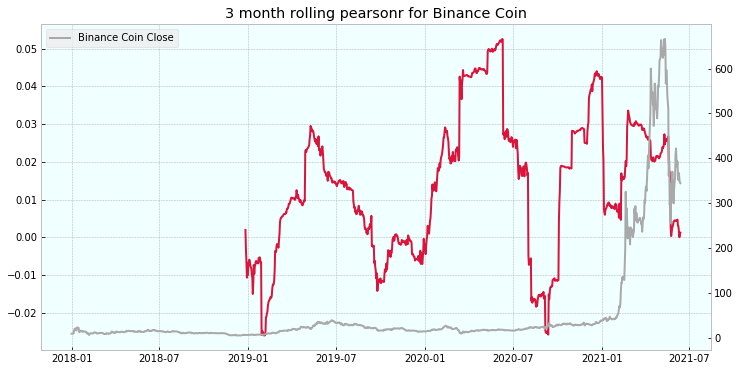

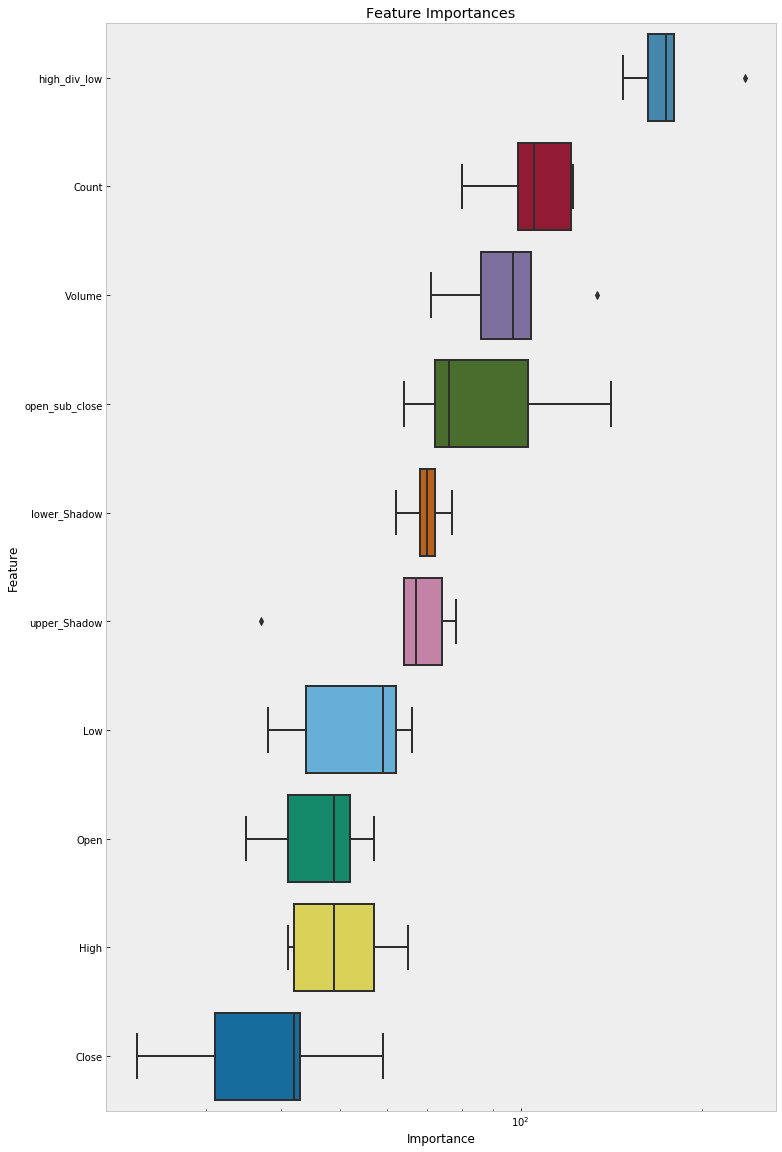



--------------------------------------------------------------------------------
Finished training EOS.IO. Results:
Model: r2_score: -0.0023724135047367145 | pearsonr: 0.004342391554794832 | wcorr: 0.004342391554794695 
Predictions std: 0.0002569207491499913 | Target std: 0.00494493082502524


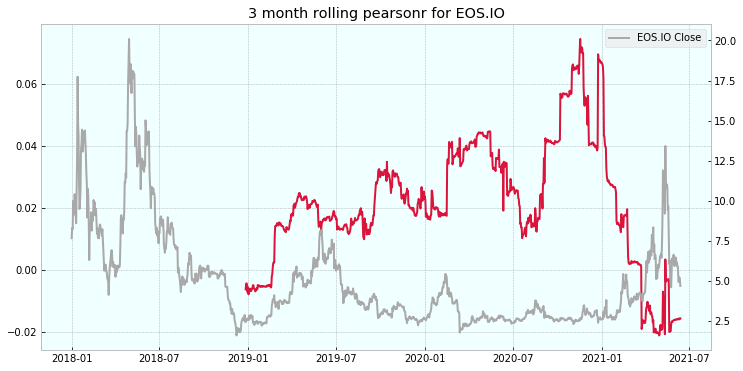

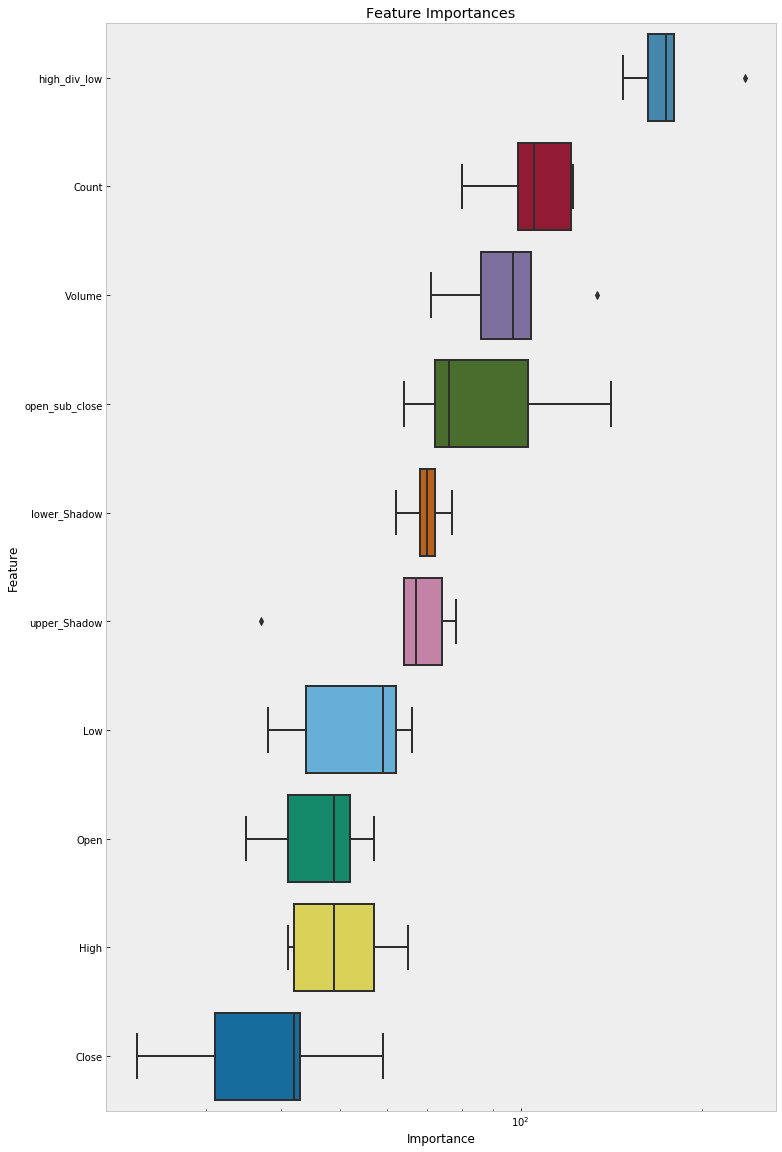



--------------------------------------------------------------------------------
Finished training Monero. Results:
Model: r2_score: -0.00029914474323566864 | pearsonr: 0.0005901770042422167 | wcorr: 0.0005901770042415782 
Predictions std: 0.000112361608752966 | Target std: 0.006331614875027146


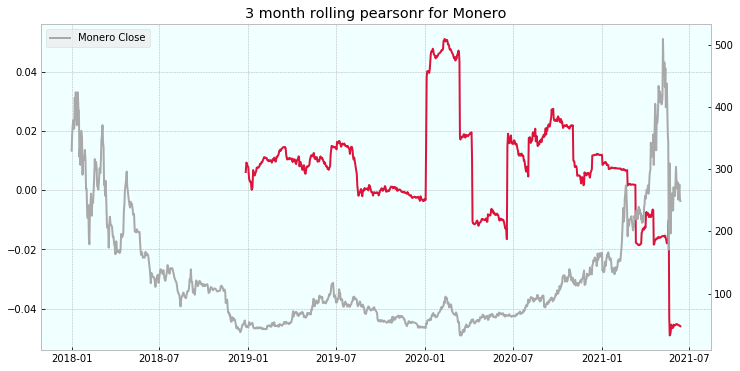

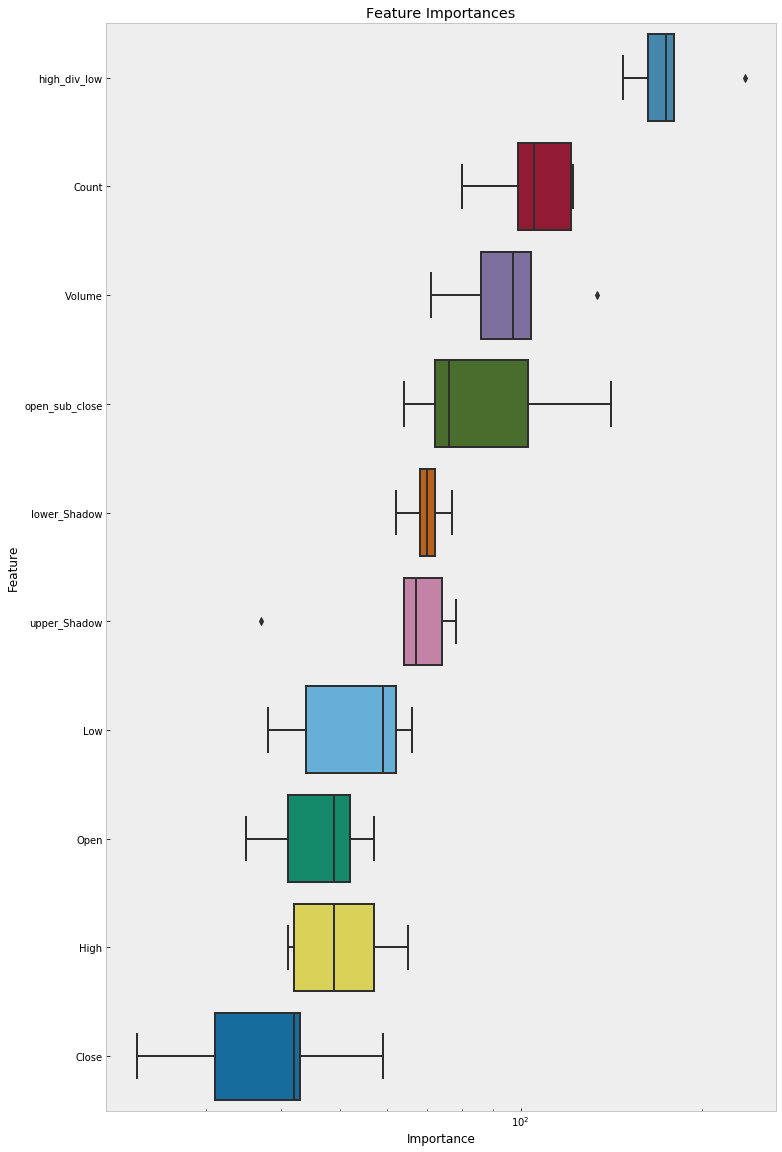



--------------------------------------------------------------------------------
Finished training Ethereum. Results:
Model: r2_score: -0.00038096506237805805 | pearsonr: 0.021813271645226402 | wcorr: 0.021813271645221295 
Predictions std: 0.00012840372612620023 | Target std: 0.002542099215310375


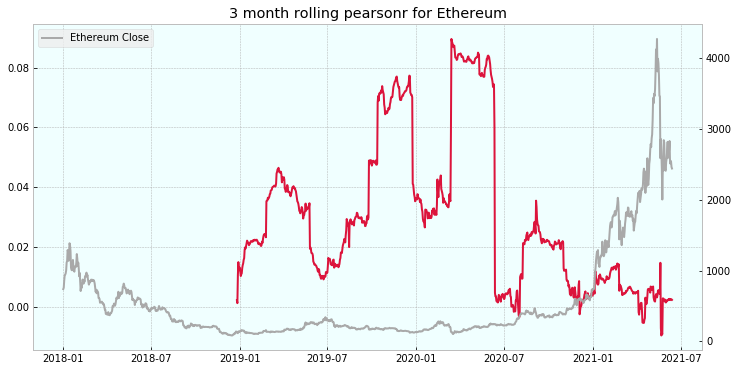

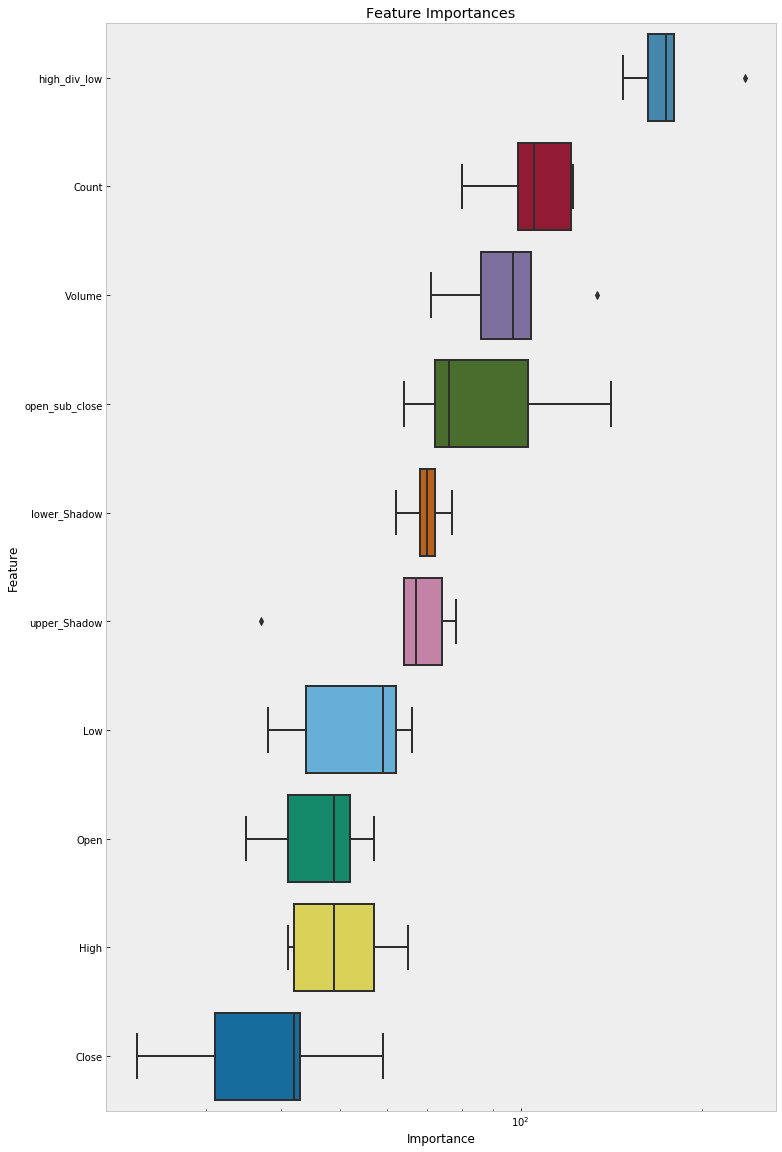



--------------------------------------------------------------------------------
Finished training Ethereum Classic. Results:
Model: r2_score: -0.009283338299944877 | pearsonr: 0.0006298636953238454 | wcorr: 0.0006298636953238788 
Predictions std: 0.0008920058625969952 | Target std: 0.009254690541410482


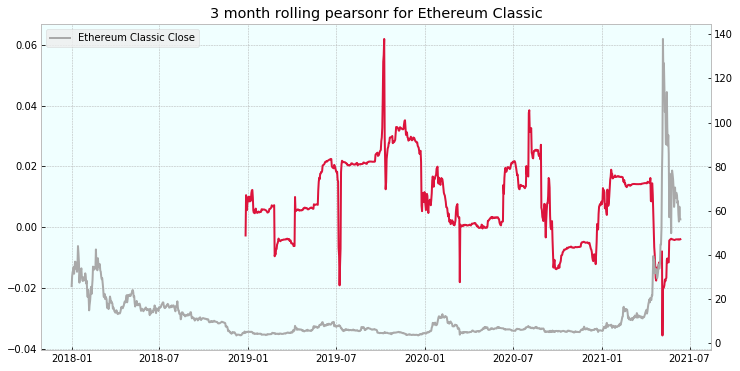

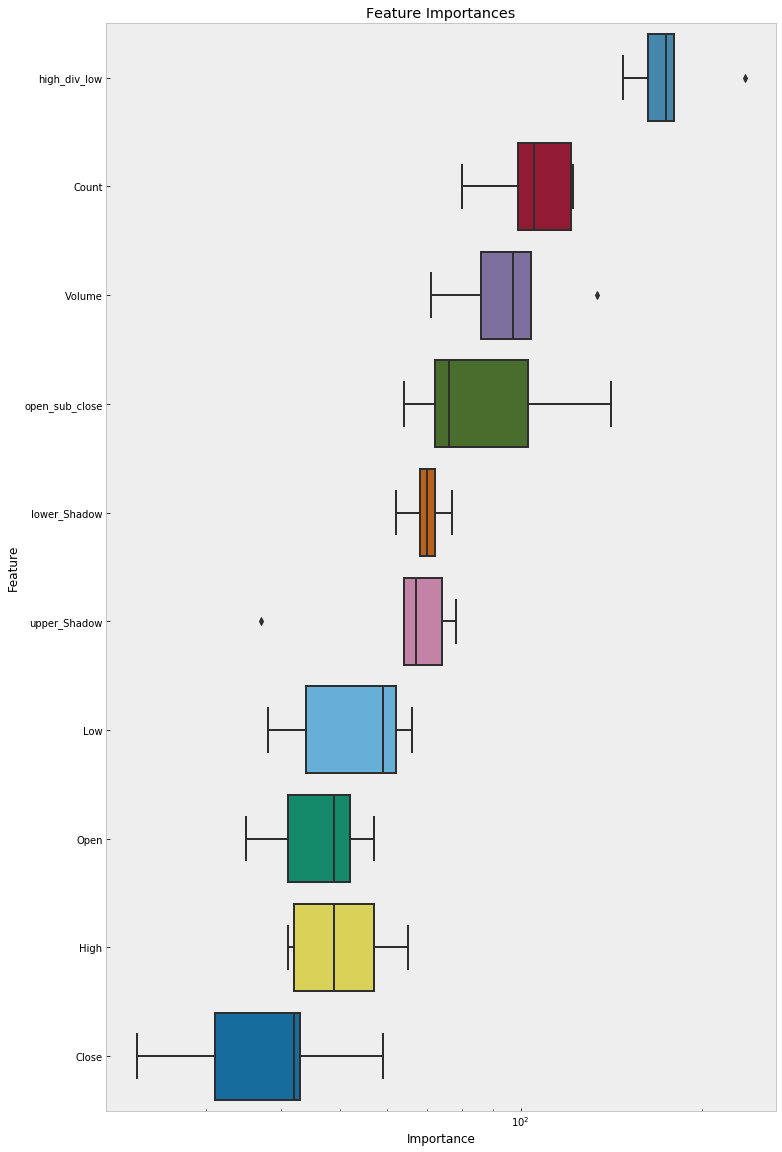



--------------------------------------------------------------------------------
Finished training Litecoin. Results:
Model: r2_score: -0.0009157996751036901 | pearsonr: 0.007981541198338934 | wcorr: 0.007981541198332623 
Predictions std: 0.00014064920086935437 | Target std: 0.003591519223735505


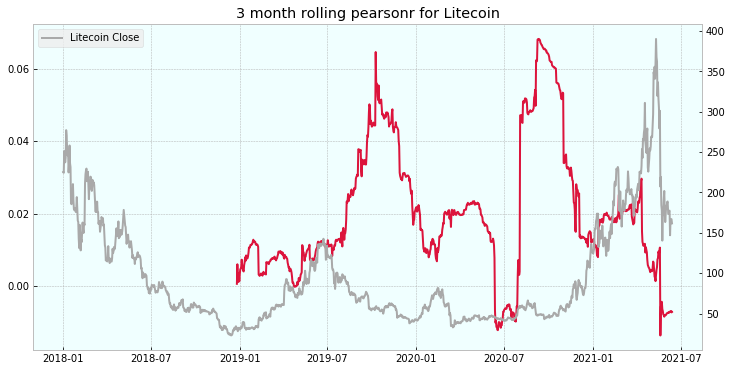

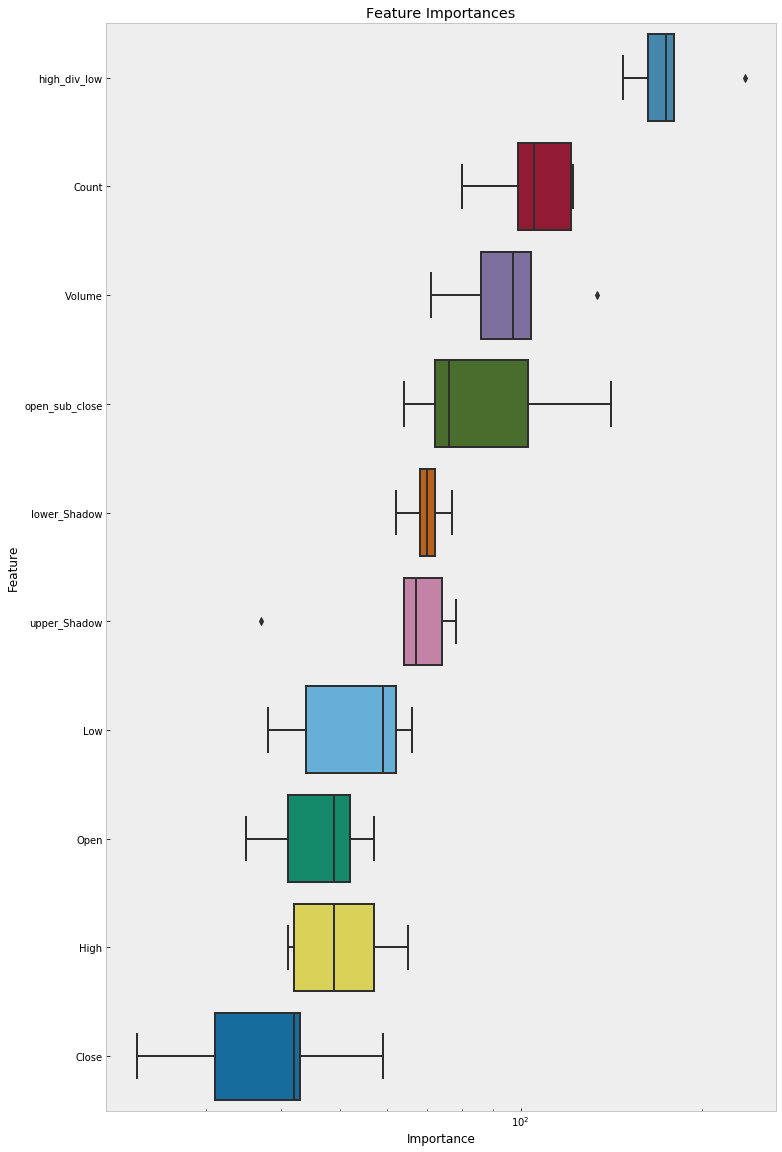



--------------------------------------------------------------------------------
Finished training Bitcoin Cash. Results:
Model: r2_score: -0.0004018658668571984 | pearsonr: 0.006216734835785995 | wcorr: 0.006216734835788587 
Predictions std: 0.00018181864432974867 | Target std: 0.00669416620808288


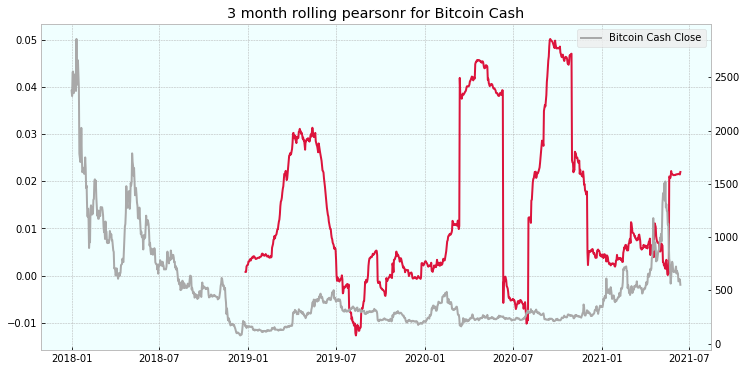

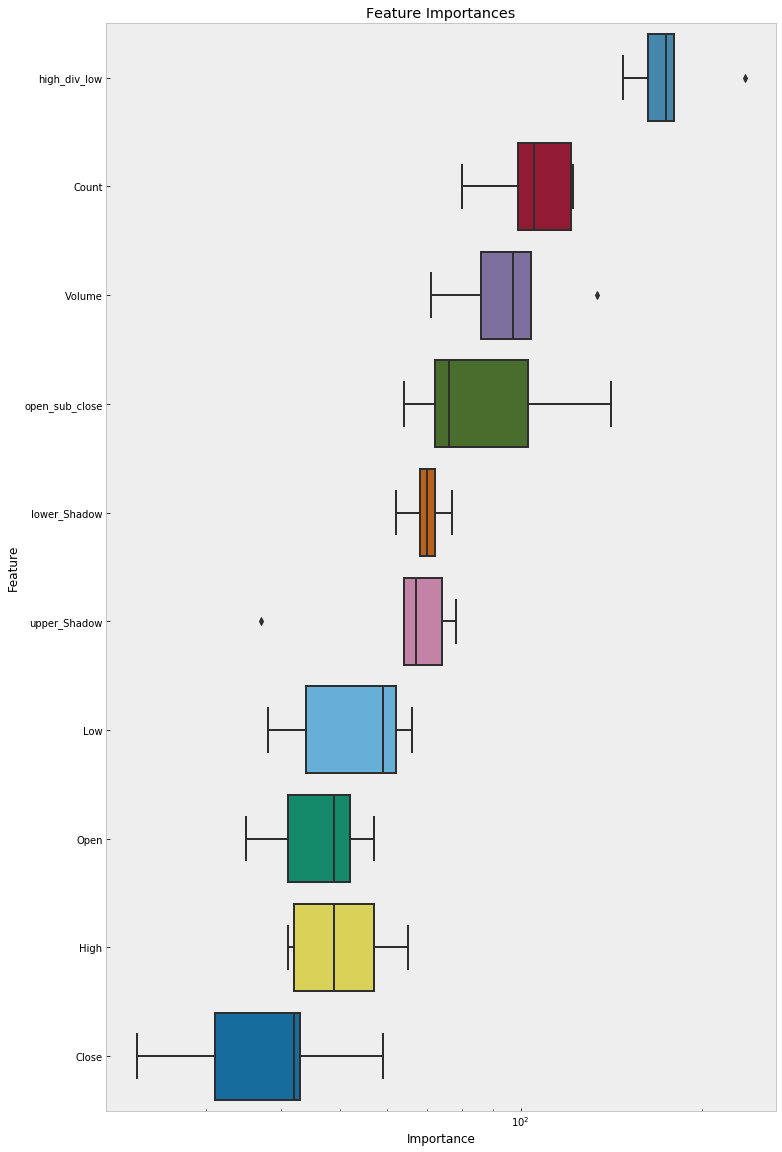



--------------------------------------------------------------------------------
Finished training Bitcoin. Results:
Model: r2_score: -0.006460070705411436 | pearsonr: -0.0013882412894285759 | wcorr: -0.0013882412894300356 
Predictions std: 0.00015895178345658217 | Target std: 0.002043465367662103


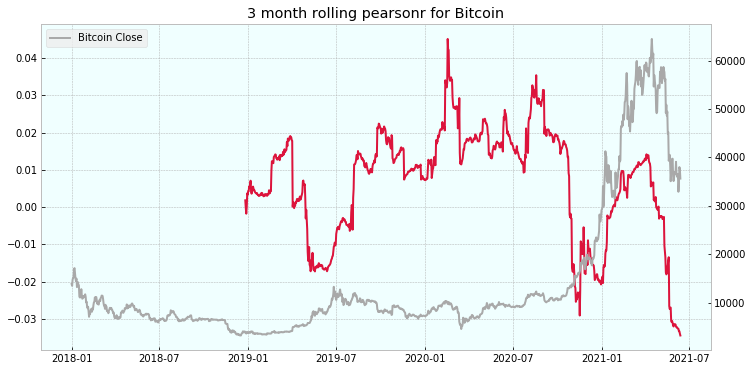

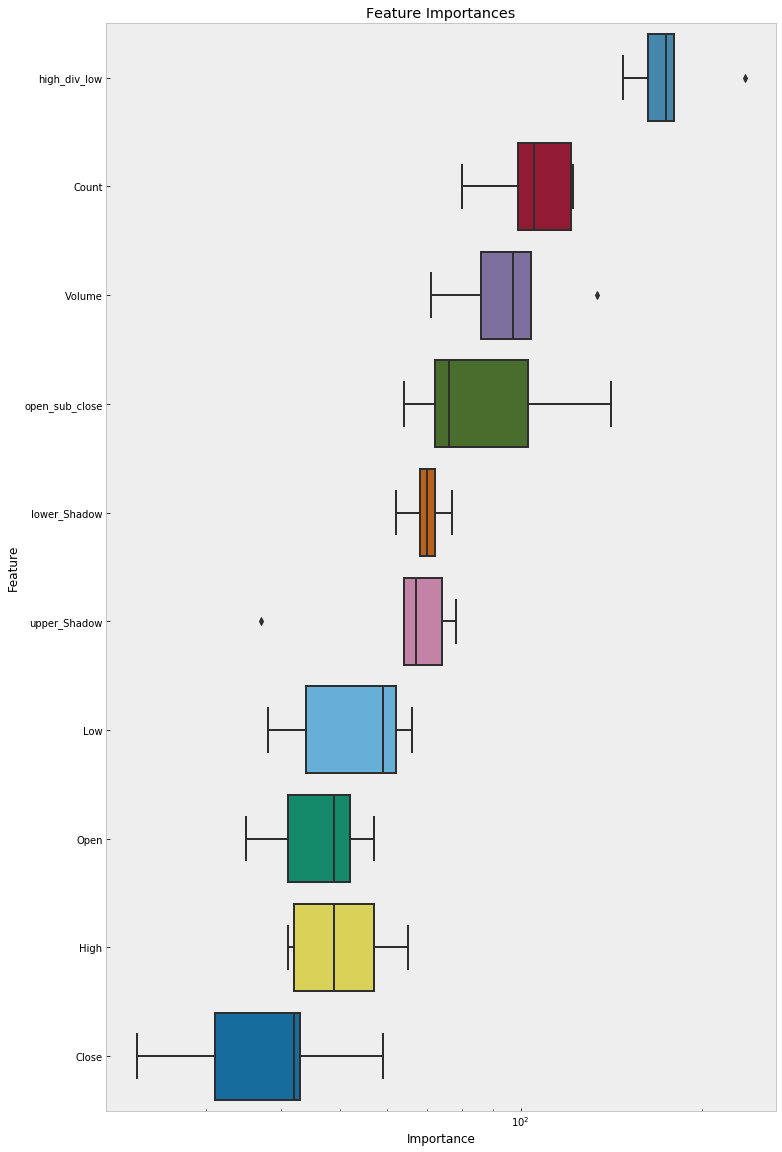



--------------------------------------------------------------------------------
Finished training TRON. Results:
Model: r2_score: -0.00773278675503386 | pearsonr: -0.013710803211504965 | wcorr: -0.013710803211505137 
Predictions std: 0.00037349854621937176 | Target std: 0.00502722999701196


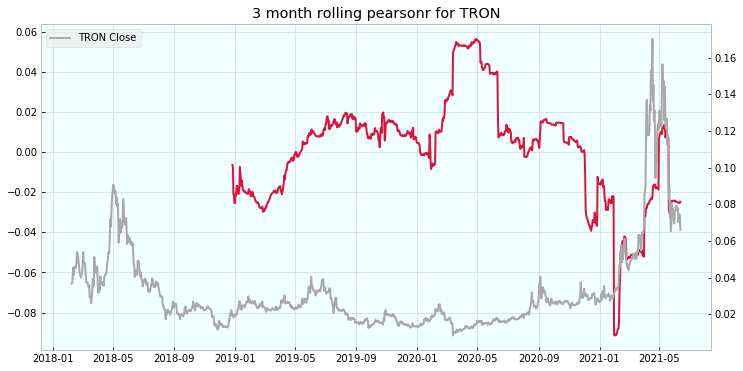

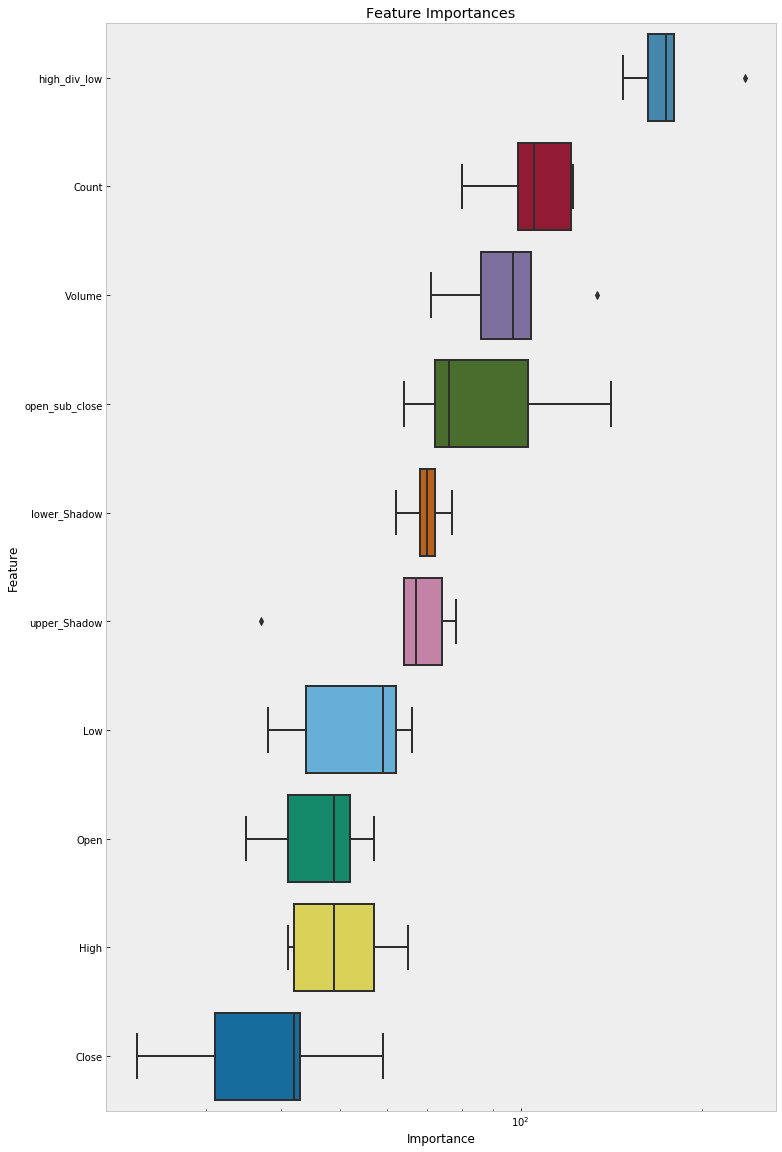



--------------------------------------------------------------------------------
Finished training Stellar. Results:
Model: r2_score: -0.002473390227844874 | pearsonr: 0.006382723527800625 | wcorr: 0.006382723527806831 
Predictions std: 0.00029743010294614884 | Target std: 0.005264874907634656


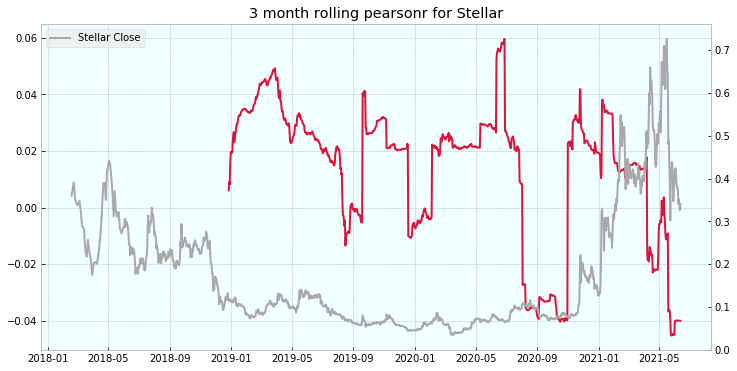

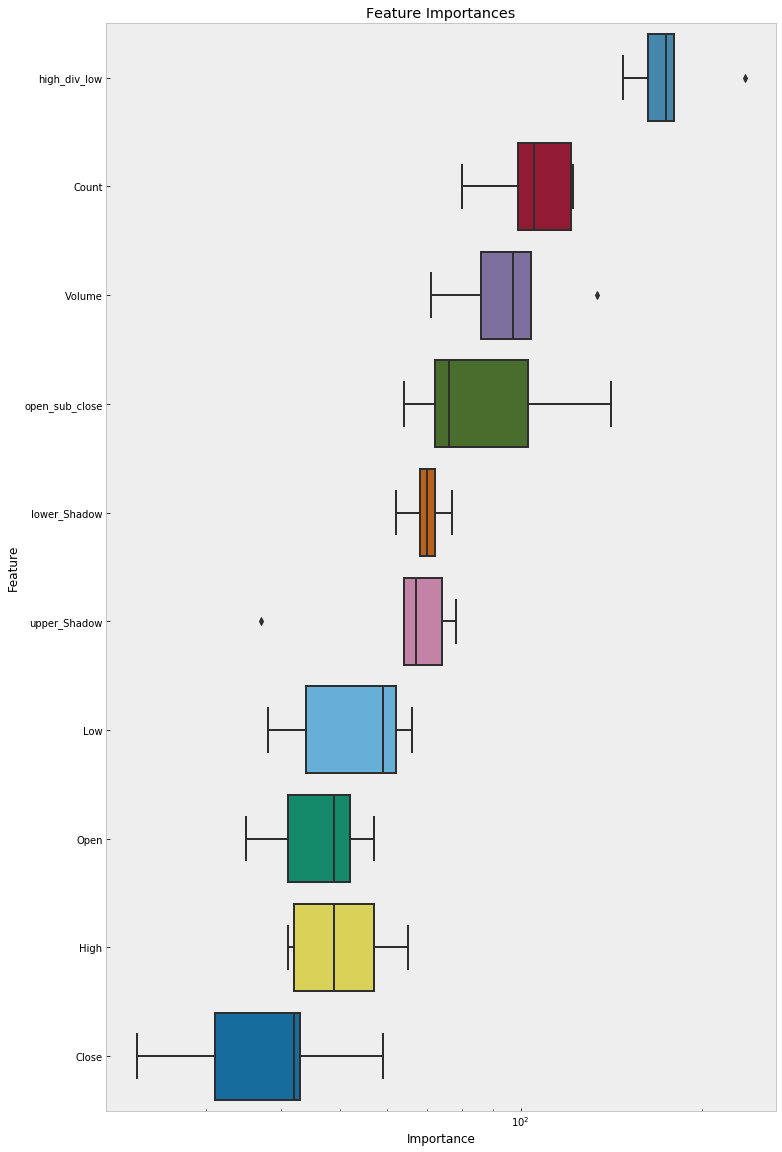



--------------------------------------------------------------------------------
Finished training Cardano. Results:
Model: r2_score: -0.002452004614291514 | pearsonr: 0.012572399198279394 | wcorr: 0.012572399198280413 
Predictions std: 0.0002903806278980101 | Target std: 0.004592266495116197


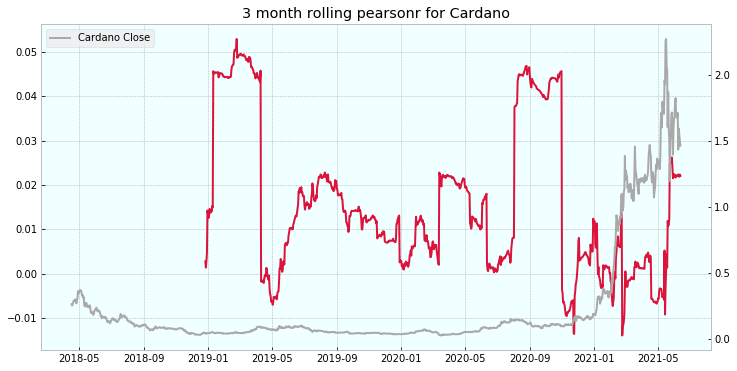

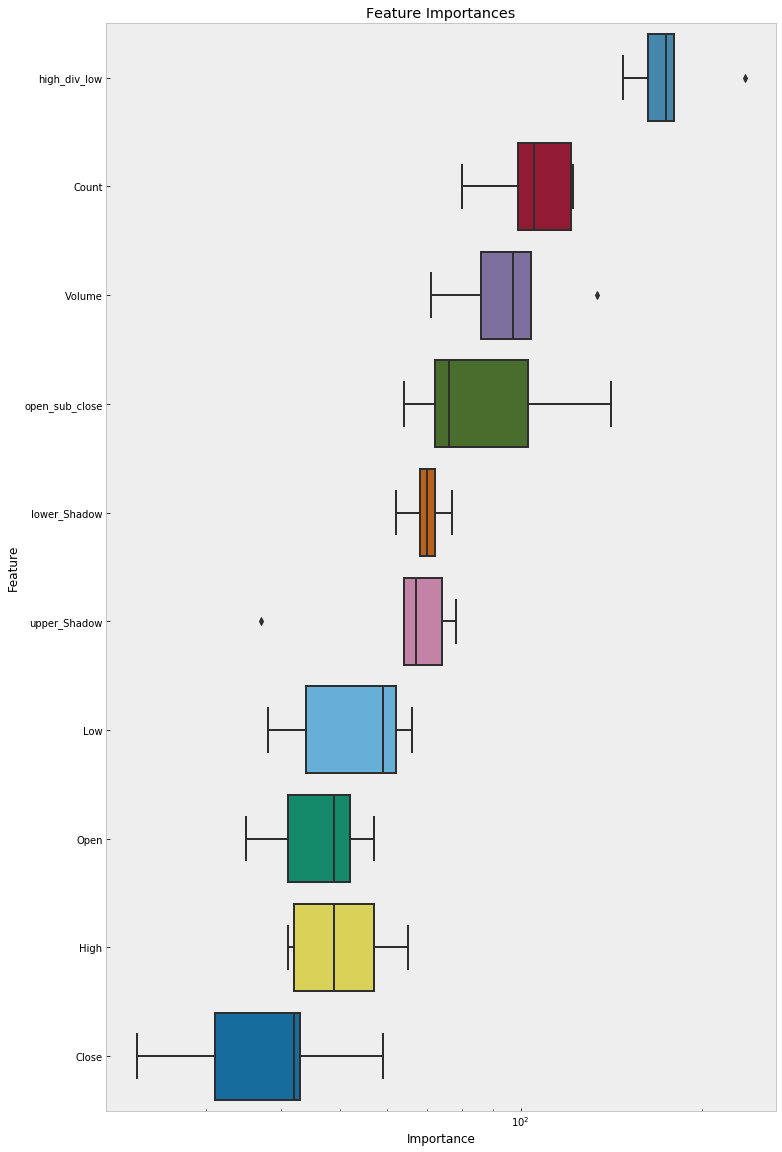



--------------------------------------------------------------------------------
Finished training IOTA. Results:
Model: r2_score: -0.0037477140986303947 | pearsonr: 0.0014128655303051094 | wcorr: 0.001412865530304206 
Predictions std: 0.0004332672430485736 | Target std: 0.006994623289398816


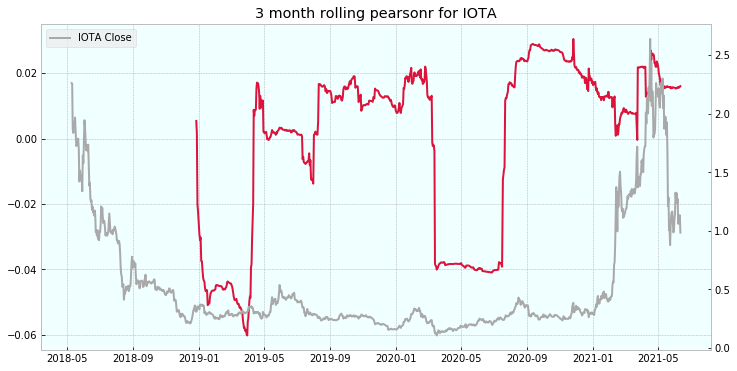

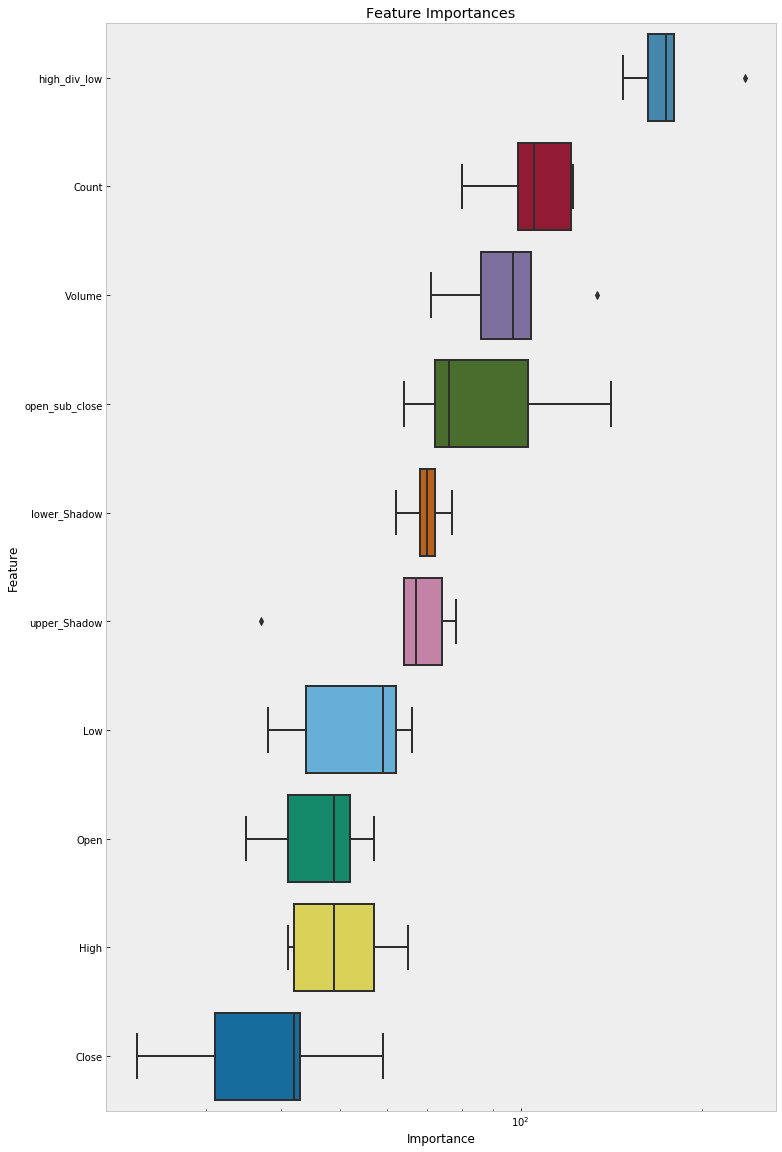



--------------------------------------------------------------------------------
Finished training Maker. Results:
Model: r2_score: -0.001162403282860991 | pearsonr: 0.015279060812272972 | wcorr: 0.015279060812269403 
Predictions std: 0.0003098968832354211 | Target std: 0.005966691452771592


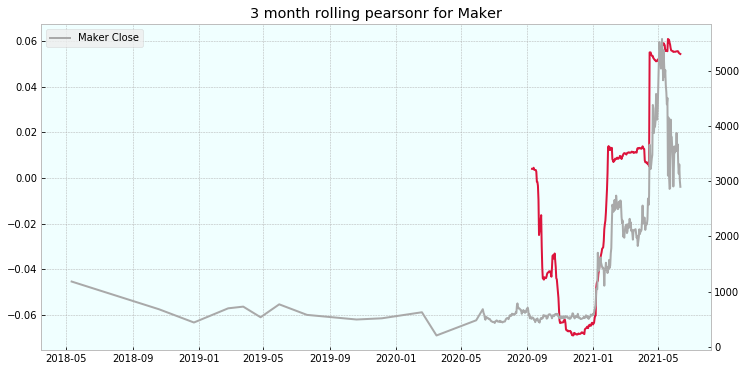

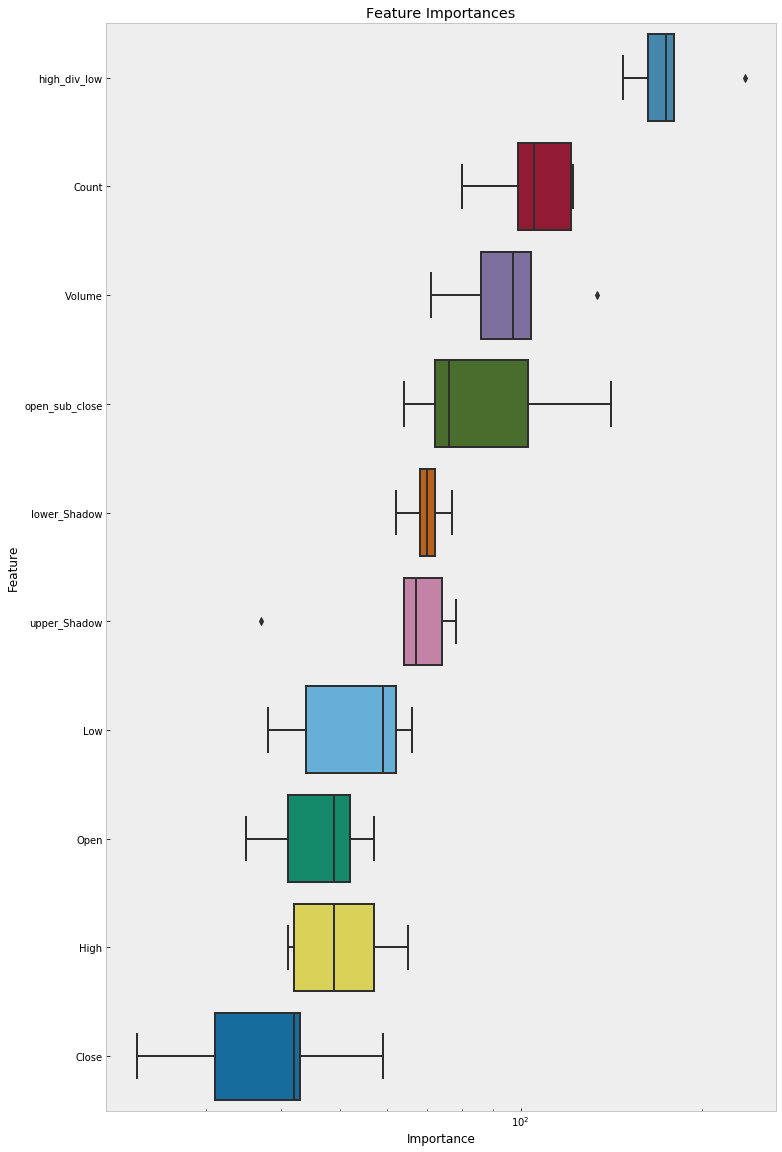



--------------------------------------------------------------------------------
Finished training Dogecoin. Results:
Model: r2_score: -0.014163993950010889 | pearsonr: 0.014443735596225244 | wcorr: 0.014443735596224975 
Predictions std: 0.001042297618619616 | Target std: 0.007992163440899364


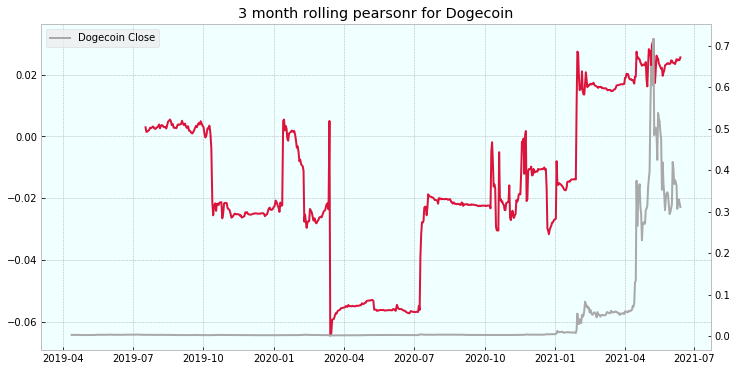

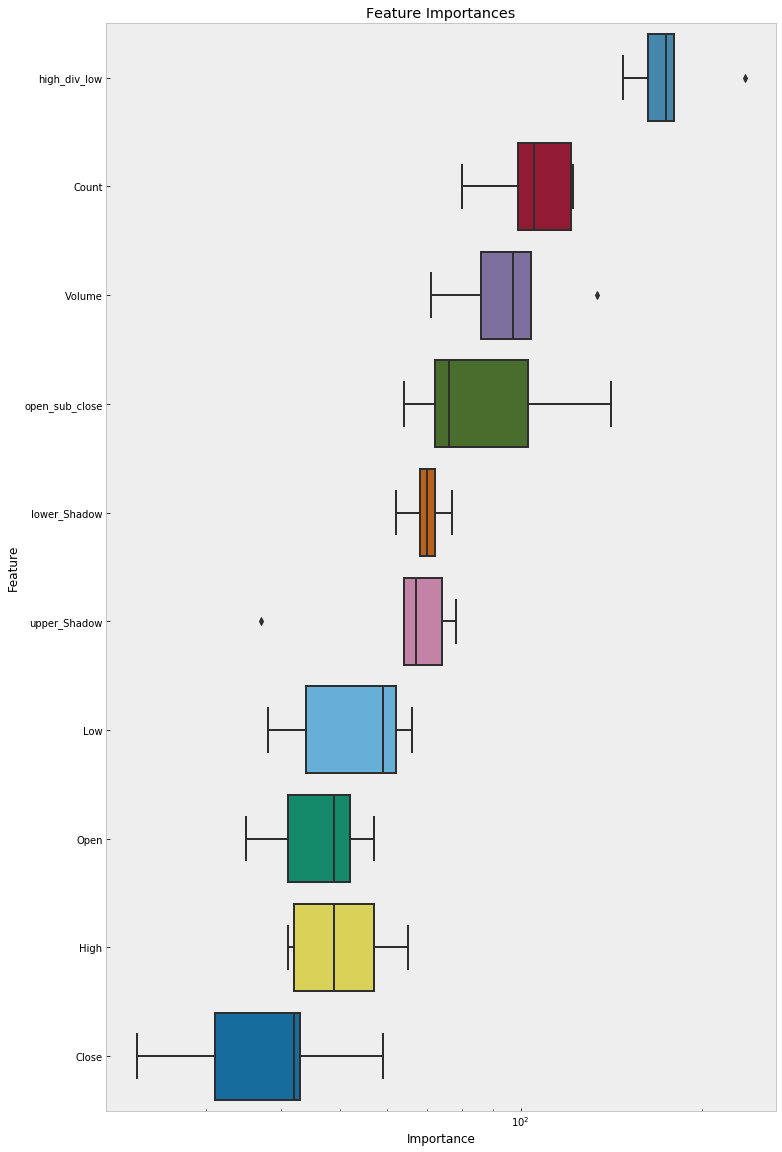

198838

In [26]:
def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(12, 20)):
    try: plt.close()
    except: pass
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    plt.title('Feature Importances')
    sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
    plt.show()
    
    
pd.DataFrame({'timestamp': train_data['timestamp'], 'asset_id': train_data['Asset_ID'], 'oof_preds': oof}).to_csv('oof.csv', index = False)

for asset in train_data['Asset_ID'].unique().tolist():       
    df = train_data.loc[train_data['Asset_ID'] == asset]
    df['oof_preds'] = np.nan_to_num(oof[train_data['Asset_ID'] == asset])
    df['Target'] = np.nan_to_num(df['Target'])
    df['y'] = np.nan_to_num(df['Target'])
    
    print('\n\n' + ('-' * 80) + '\n' + 'Finished training %s. Results:' % asset_name_dict[asset])
    print('Model: r2_score: %s | pearsonr: %s | wcorr: %s ' % (r2_score(df['y'], df['oof_preds']), pearsonr(df['y'], df['oof_preds'])[0], corr(df['y'].values, df['oof_preds'].values, np.array([asset_weight_dict[asset_id]] * len(df['y'].values)))))
    print('Predictions std: %s | Target std: %s' % (df['oof_preds'].std(), df['y'].std()))
    
    try: plt.close()
    except: pass   
    df2 = df.reset_index().set_index('date')
    fig = plt.figure(figsize = (12, 6))
    # fig, ax_left = plt.subplots(figsize = (12, 6))
    ax_left = fig.add_subplot(111)
    ax_left.set_facecolor('azure')    
    ax_right = ax_left.twinx()
    ax_left.plot(df2['y'].rolling(3 * 30 * 24 * 60).corr(df2['oof_preds']).iloc[::24 * 60], color = 'crimson', label = "Target WCorr")
    ax_right.plot(df2['Close'].iloc[::24 * 60], color = 'darkgrey', label = "%s Close" % asset_name_dict[asset])   
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.title('3 month rolling pearsonr for %s' % (asset_name_dict[asset]))
    plt.show()
    
    plot_importance(np.array(importances), feature_names, PLOT_TOP_N = 20)
    
gc.collect()